In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

1

In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
from pycmqlib3.utility import dbaccess, dataseries, misc
from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
matplotlib.rcParams['figure.figsize'] = (12, 8)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2023, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# define product groups and start times

In [3]:
ferrous_products_mkts = ['rb', 'hc', 'i', 'j', 'jm']
ferrous_mixed_mkts = ['ru', 'FG', 'SM', "SF", 'nr', 'SA', 'UR'] # 'ZC', 
base_metal_mkts = ['cu', 'al', 'zn', 'pb', 'ni', 'sn', 'ss']
precious_metal_mkts = ['au', 'ag']
ind_metal_mkts = ferrous_products_mkts + ferrous_mixed_mkts + base_metal_mkts  
petro_chem_mkts = ['l', 'pp', 'v', 'TA', 'MA', 'bu', 'sc', 'fu', 'eg', 'eb', 'lu', 'pg', 'PF'] 
ind_all_mkts = ind_metal_mkts + petro_chem_mkts
ags_oil_mkts = ['m', 'RM', 'y', 'p', 'OI', 'a', 'c', 'cs', 'b'] #, 'b']
ags_soft_mkts = ['CF', 'SR', 'jd', 'AP', 'sp', 'CJ', 'lh', 'PK', 'CY'] # 'CY',] 

ags_all_mkts = ags_oil_mkts + ags_soft_mkts

eq_fut_mkts = ['IF', 'IH', 'IC']
bond_fut_mkts = ['T', 'TF', 'TS']

fin_all_mkts = eq_fut_mkts + bond_fut_mkts
commod_all_mkts = ind_all_mkts + ags_all_mkts + precious_metal_mkts
all_markets = commod_all_mkts + fin_all_mkts

daily_start_dict = { 'c': datetime.date(2011,1,1), 'm': datetime.date(2011,1,1),
    'y': datetime.date(2011,1,1), 'l': datetime.date(2011,1,1), 'rb':datetime.date(2011,1,1),
    'p': datetime.date(2011,1,1), 'cu':datetime.date(2011,1,1), 'al':datetime.date(2011,1,1),
    'zn':datetime.date(2011,1,1), 'au':datetime.date(2015,12,1), 'v': datetime.date(2011,1,1),
    'a': datetime.date(2011,1,1), 'ru':datetime.date(2011,1,1), 'ag':datetime.date(2012,6,1),
    'i': datetime.date(2014,1,1), 'j': datetime.date(2012,6,1), 'jm':datetime.date(2013,7,1),
    'CF':datetime.date(2012,5,1),  'TA':datetime.date(2012,4,15),
    'PM':datetime.date(2013,10,1), 'RM':datetime.date(2013,1,1),  'SR':datetime.date(2013,1,1),
    'FG':datetime.date(2013,1,1),  'OI':datetime.date(2013,5,1),  'RI':datetime.date(2013,1,1),
    'WH':datetime.date(2014,5,1),  'pp':datetime.date(2014,5,1),
    'IF':datetime.date(2010,5,1),  'MA':datetime.date(2012,1,1),  'TF':datetime.date(2019,6,1),
    'IH':datetime.date(2015,5,1),  'IC':datetime.date(2015,5,1),  'cs':datetime.date(2015,2,1),
    'jd':datetime.date(2014,5,1),  'ni':datetime.date(2015,9,1),  'sn':datetime.date(2017,5,1),
    'ZC':datetime.date(2013,11,1), 'hc':datetime.date(2016, 4, 1), 'SM': datetime.date(2017,1,1),
    'SF': datetime.date(2017,9,1), 'CY': datetime.date(2017, 9, 1), 'AP': datetime.date(2018, 1, 1),
    'TS': datetime.date(2018, 9, 1), 'fu': datetime.date(2018, 9, 1), 'sc': datetime.date(2018, 10, 1),
    'b': datetime.date(2018, 1, 1), 'pb': datetime.date(2016, 7, 1), 'bu': datetime.date(2015,9,15),
    'T':datetime.date(2019,4,1), 'ss': datetime.date(2020, 5, 1), 'sp': datetime.date(2019, 5, 1),
    'CJ': datetime.date(2019, 8, 9), 'UR': datetime.date(2019, 8, 9), 'SA': datetime.date(2020, 1, 1),
    'eb': datetime.date(2020, 2, 1), 'eg': datetime.date(2019, 4, 2), 'rr': datetime.date(2019, 9, 1),
    'pg': datetime.date(2020, 9, 5), 'lu': datetime.date(2020, 10, 1), 'nr': datetime.date(2020,1,1),
    'lh': datetime.date(2021,5,1), 'PF': datetime.date(2021,1,1), 'PK': datetime.date(2021,4,1), }

# load historical data

In [4]:
fields = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

start_date = datetime.date(2010,1,1)
end_date = datetime.date(2023,6,16)
shift_mode = 2
roll_name = 'hot'
roll_file_loc = "C:/dev/wtdev/config/"
sim_markets = all_markets
nb_cont = 2
freq='d1'

data_df = pd.DataFrame()

for prodcode in sim_markets:
    for nb in range(nb_cont):
        xdf = dataseries.nearby(prodcode,
                                nb+1,
                                start_date=start_date, 
                                end_date = end_date, 
                                shift_mode = shift_mode,
                                freq=freq, 
                                roll_name=roll_name, 
                                config_loc=roll_file_loc)
        xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
        xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
        xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
        xdf['product'] = prodcode
        xdf['code'] = f'c{nb+1}'
        data_df = data_df.append(xdf)

df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = list(fields), aggfunc = 'last')
df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
df.columns.rename(['product', 'code', 'field',], inplace = True)
df.index = pd.to_datetime(df.index)
df.tail(5)

product         AP                                                         \
code            c1                                                          
field        close contract  diff_oi      expiry    high     low      mth   
date                                                                        
2023-06-12  8428.0   AP2310  21590.0  2023-10-20  8650.0  8396.0  24286.0   
2023-06-13  8439.0   AP2310 -16267.0  2023-10-20  8478.0  8417.0  24286.0   
2023-06-14  8461.0   AP2310   -304.0  2023-10-20  8465.0  8365.0  24286.0   
2023-06-15  8440.0   AP2310  -2518.0  2023-10-20  8480.0  8375.0  24286.0   
2023-06-16  8556.0   AP2310  -5946.0  2023-10-20  8626.0  8457.0  24286.0   

product                                                                   \
code                                                 c2                    
field         open openInterest shift    volume   close contract diff_oi   
date                                                                       
2023-06-12  8650.0     163909.0   0.0  175376.0  8396.0   AP2401  2421.0   
2023-06-13  8443.0     147642.0   0.0   71089.0  8403.0   AP2401  -227.0   
2023-06-14  8439.0     147338.0   0.0   25352.0  8420.0   AP2401   -58.0   
2023-06-15  8443.0     147680.0   0.0  111446.0  8406.0   AP2401    69.0   
2023-06-16  8457.0     141734.0   0.0  141683.0  8516.0   AP2401     4.0   

product                                                                     \
code                                                                         
field           expiry    high     low      mth    open openInterest shift   
date                                                                         
2023-06-12  2024-01-12  8560.0  8367.0  24289.0  8560.0      21500.0   0.0   
2023-06-13  2024-01-12  8433.0  8382.0  24289.0  8400.0      21273.0   0.0   
2023-06-14  2024-01-12  8426.0  8337.0  24289.0  8400.0      21215.0   0.0   
2023-06-15  2024-01-12  8451.0  8358.0  24289.0  8400.0      21684.0   0.0   
2023-06-16  2024-01-12  8570.0  8402.0  24289.0  8411.0      21688.0   0.0   

product                  CF                                                  \
code                     c1                                                   
field       volume    close contract  diff_oi      expiry     high      low   
date                                                                          
2023-06-12  7183.0  16755.0   CF2309 -11868.0  2023-09-14  16830.0  16580.0   
2023-06-13  1972.0  16870.0   CF2309   1850.0  2023-09-14  16905.0  16595.0   
2023-06-14  1328.0  16830.0   CF2309 -17978.0  2023-09-14  16935.0  16715.0   
2023-06-15  3623.0  16770.0   CF2309    394.0  2023-09-14  17000.0  16725.0   
2023-06-16  5717.0  16795.0   CF2309  -1390.0  2023-09-14  17020.0  16700.0   

product                                                                      \
code                                                            c2            
field           mth     open openInterest shift    volume    close contract   
date                                                                          
2023-06-12  24285.0  16765.0     616378.0   0.0  639852.0  16750.0   CF2401   
2023-06-13  24285.0  16765.0     618228.0   0.0  595256.0  16810.0   CF2401   
2023-06-14  24285.0  16875.0     600250.0   0.0  439499.0  16805.0   CF2401   
2023-06-15  24285.0  16810.0     600647.0   0.0  699880.0  16700.0   CF2401   
2023-06-16  24285.0  16800.0     599211.0   0.0  556484.0  16785.0   CF2401   

product                                                             \
code                                                                 
field      diff_oi      expiry     high      low      mth     open   
date                                                                 
2023-06-12  6548.0  2024-01-12  16865.0  16645.0  24289.0  16800.0   
2023-06-13 -2538.0  2024-01-12  16830.0  16605.0  24289.0  16750.0   
2023-06-14   -42.0  2024-01-12  16870.0  16700.0  24289.0  16800.0   
2023

# Calculate features

In [27]:
leadlag_portfolio = {
    'ferrous': {'lead': ['hc', 'rb', ],
                'lag': ['rb', 'hc', 'i', 'j', 'jm', 'SM', ],
                'param_rng': [40, 60, 2],
                },
    'constrs': {'lead': ['hc', 'rb', 'v'],
                'lag': ['FG', 'SA', 'v', 'UR', ],
                'param_rng': [40, 60, 2],
                },
    'petchem': {'lead': ['v'],
                'lag': ['TA', 'MA', 'pp', 'eg', 'eb', 'PF', ],
                'param_rng': [40, 60, 2],
                },
    'base': {'lead': ['al'],
             'lag': ['al', 'ni', 'sn', 'ss', ],  # 'zn', 'cu'
             'param_rng': [40, 60, 2],
             },
    'oil': {'lead': ['sc'],
            'lag': ['sc', 'pg', 'bu', ],
            'param_rng': [20, 30, 2],
            },
    'bean': {'lead': ['b'],
             'lag': ['p', 'y', 'OI', ],
             'param_rng': [60, 80, 2],
             },
}


leadlag_repo = {
    'ferrous': {'lead': ['hc', 'rb', 'v'],
                'lag': ['rb', 'hc', 'i', 'j', 'jm', 'SM', 'FG', 'SA', 'v', 'UR', 'SF'],
                'param_rng': [40, 80, 2],
                },
    'petchem': {'lead': ['v'],
                'lag': ['TA', 'MA', 'pp', 'eg', 'eb', 'PF',  'al', 'cu', 'zn',], # 
                'param_rng': [40, 80, 2],
                },
#     'base0': {'lead': ['v'],
#              'lag': ['al', 'cu', 'zn',],  # 'zn', 'cu'
#              'param_rng': [40, 60, 2],
#              },
    'base': {'lead': ['al'],
             'lag': ['ni', 'sn', 'ss', ],  # 'zn', 'cu'
             'param_rng': [40, 80, 2],
             },
    'oil': {'lead': ['sc'],
            'lag': ['sc', 'pg', 'bu', ],
            'param_rng': [20, 30, 2],
            },
    'bean': {'lead': ['b'],
             'lag': ['p', 'y', 'OI', ],
             'param_rng': [60, 80, 2],
             },
}

asset_list = [
    'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'SM', 'UR', #'SF', 'al', 'SA', 
#     'sc',
#     'ni', 'sn', 'ss', 
#     'TA', 'pp', 'eg', 'eb', 
#     'p', 'y', 'OI',
]

input_args = {
    'product_list': asset_list,
    'conv_func': 'qtl',
    'signal_cap': None,
}


def lead_lag(df, input_args, leadlag_port=leadlag_portfolio):
    product_list = input_args['product_list']
    signal_cap = input_args.get('signal_cap', None)
    conv_func = input_args.get('conv_func', 'qtl')
    signal_df = pd.DataFrame(index=df.index, columns=product_list)
    for asset in product_list:
        for sector in leadlag_port:
            if asset in leadlag_port[sector]['lag']:
                signal_list = []
                for lead_prod in leadlag_port[sector]['lead']:
                    feature_ts = df[(lead_prod, 'c1', 'close')]
                    signal_ts = calc_conv_signal(feature_ts.dropna(), conv_func,
                                                 leadlag_port[sector]['param_rng'], signal_cap=signal_cap)
                    signal_list.append(signal_ts)
                signal_df[asset] = pd.concat(signal_list, axis=1).mean(axis=1)
                break
            else:
                signal_df[asset] = 0
    return signal_df


signal_df = lead_lag(df, input_args, leadlag_repo)

# signal_df = pd.DataFrame(index=df.index, columns=asset_list)
# for asset in asset_list:
#     signal_df[asset] = calc_conv_signal(df[(asset, 'c1', 'close')].dropna(), 'qtl', [40, 80, 2], signal_cap=None)
# signal_df


C:\dev\pyktrader3\pycmqlib3\analytics\backtest_utils.py:226: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  xdf[(asset, 'traded_price')] = xdf[(asset, exec_mode)].shift(-1)
C:\dev\pyktrader3\pycmqlib3\analytics\backtest_utils.py:231: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  xdf[(asset, 'px_chg')] = xdf[(asset, 'traded_price')].pct_change()


portfolio sharpe:
%s
 sharpe       1.410942
sharpe_6m    0.189392
sharpe_1y    1.237336
sharpe_2y    0.885106
sharpe_3y    1.780594
sharpe_4y    1.499792
sharpe_5y    1.425722
sharpe_6y    1.379259
sharpe_7y    1.415531
sharpe_8y    1.565064
sharpe_9y    1.432580
Name: total, dtype: float64
asset sharpe:
%s
 product          rb        hc         i         j        jm        FG  \
sharpe     1.237697  1.222848  1.281084  1.540293  0.957167  0.671812   
sharpe_6m  0.200547  0.223373  0.003252  0.150809  0.186161 -0.312207   
sharpe_1y  1.074358  1.159581  0.552321  0.659031  0.776287  0.803719   
sharpe_2y  0.298135  0.498231 -0.092842  0.742907  0.996669  0.382804   
sharpe_3y  1.061918  1.502789  0.999028  0.924729  1.251340  1.560013   
sharpe_4y  0.749206  1.237100  0.915729  0.871934  0.993862  1.173464   
sharpe_5y  0.892090  1.171021  1.079607  0.855542  0.749374  0.991639   
sharpe_6y  0.812532  1.066347  0.958094  1.043806  0.748917  0.860595   
sharpe_7y  0.831954  1.067387  1.

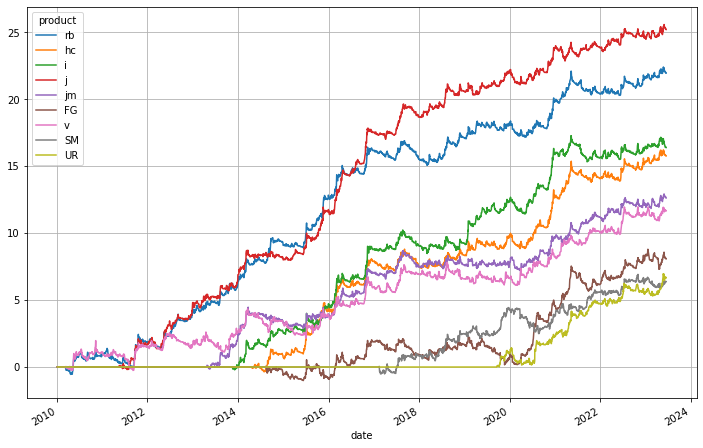

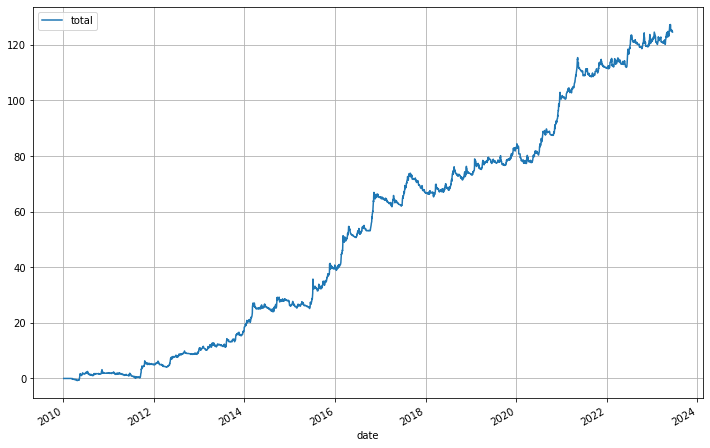

In [28]:
vol_win=20
vol_df = get_asset_vols(df, asset_list, vol_win=vol_win, vol_type='pct_chg')

holding = generate_holding_from_signal(signal_df, vol_df,
                                       risk_scaling=1.0,
                                       asset_scaling=False)
df_pxchg = get_px_chg(df, exec_mode='open', chg_type='pct', contract='c1')
df_pxchg = df_pxchg[asset_list].reindex(index=holding.index)

bt_metrics = MetricsBase(holdings=holding[asset_list],
                         returns=df_pxchg[asset_list])

pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y']
pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, use_log_returns=False, tenors=pnl_tenors, perf_metrics=['sharpe', 'std'])
print('portfolio sharpe:\n%s\n', pnl_stats['sharpe'])
print('asset sharpe:\n%s\n', pnl_stats['asset_sharpe_stats'])
print('turnover: %s\n pnl_per_trade: %s\n' % (pnl_stats['turnover'], pnl_stats['pnl_per_trade']))

pnl_stats['asset_cumpnl'].plot()
plt.grid()
plt.show()
pnl_stats['portfolio_cumpnl'].plot()
plt.grid()
plt.show()


In [30]:
pnl_stats['portfolio_pnl'].to_csv('ll_ferrous_pnl.csv')